### Import statements

In [ ]:
%%capture

import numpy as np
import tensorflow as tf

#mandatory for correct load and save of files
%cd /Users/paolobonomi/work/python/capsnet

# for project class
import sys
sys.path.append("./src")

from setup import Setup # set up model and dataset
import perfu # performance function such as confusion matrix etc...
import printer

### AFFNIST Retrieve model and dataset

In [ ]:
def _process_data(x, y, shuffle):
    x_ = x
    y_ = y

    x_ = x_ / 255.0
    x_ = tf.cast(x_, dtype=tf.float32)
    x_ = tf.expand_dims(x_, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices((x_, y_))
    if shuffle:

        dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=True)

    dataset = dataset.batch(batch_size=64)
    return x_, y_, dataset

In [ ]:
import scipy.io as spio
import numpy as np

#test set is 10k per batch, trainning set is 50k per batch

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)


def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        


def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

def _unpack(dataset):
    ans_set = dataset['affNISTdata']['label_int']
    img_set = dataset['affNISTdata']['image']
    trans = dataset['affNISTdata']['human_readable_transform']
    
    img_set = np.transpose(img_set)
    img_set = np.reshape(img_set, (-1, 40, 40))
    ans_set = ans_set.astype(np.uint8)

    return img_set, ans_set, trans

def load(train):
    s = "training" if train else "test"

    if train:
        path = './data/affNIST/'+s+'_batches/1.mat'
        data = _unpack(loadmat(path))
    else:
        path = './data/affNIST/'+s+'_batches/1.mat'
        img_set, ans_set, trans = _unpack(loadmat(path))

    return img_set, ans_set, trans

def load_affnist_transformations(train):
    s = "training" if train else "test"

    if train:
        path = './data/affNIST/'+s+'_batches/1.mat'
        data = _unpack(loadmat(path))
    else:
        path = './data/affNIST/'+s+'_batches/1.mat'
        img_set, ans_set, trans = _unpack(loadmat(path))

    return trans

def load_MNIST(train):
    s = "training" if train else "test"
    path = './data/affNIST/originals/'+s+'.mat'
    img_set, ans_set, trans = _unpack(loadmat(path))
    return img_set, ans_set

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as fn

def convert_to_torch(img):
    rx = torch.from_numpy(img)
    rx = torch.unsqueeze(rx, 0)
    return rx

def convert_to_tensor(img):
    rx = tf.convert_to_tensor(img, dtype=tf.dtypes.float32)
    rx = np.reshape(rx, [1, 40, 40])
    return rx

def apply_scaling(img, x, y, mode):
    i = int(40*y)
    j = int(40*x)
    rx = fn.resize(img, size=[ i, j ], interpolation=mode)
    rx = fn.center_crop(rx, [40, 40])
    return rx

def apply_transformation(img, data, id, mode=transforms.InterpolationMode.BILINEAR):
    rotation = data[0][id] #counter clock wise between -20 and +20
    shearing = data[1][id] #shearing between -0.2 and +0.2. if shear 1 horiz line turns into 45 degree line
    y_scale = data[2][id]
    x_scale = data[3][id] # between 0.8 (shrinking by 20%) and 1.2 (making 20% larger).
    v_trasl = data[4][id]
    h_trasl = data[5][id] # 
    
    rx = convert_to_torch(img)    
    rx = fn.affine(rx, rotation*-1, [0, 0], 1, [0, shearing*-45], interpolation=mode)
    rx = apply_scaling(rx, x_scale, y_scale, mode)
    #rx = fn.affine(rx, 0, [h_trasl*0.4, v_trasl*0.4], 1, 0, interpolation=mode)

    rx = convert_to_tensor(rx)
    rx = tf.reshape(rx, [40, 40])
    return rx

def create_affnist(train):
    x, y = load_MNIST(train)
    t = load_affnist_transformations(train)

    for i in range(0, x.shape[0]): 
        x[i] = apply_transformation(x[i], t, i)
        
    return x, y

def check_bounds(x, rx):
    a = np.sum(x)
    b = torch.sum(rx).item()
    c = abs(a - b)
    return c >= 1

def apply_random_translation(img, size=40, mode=transforms.InterpolationMode.BILINEAR):
    rx = convert_to_torch(img)
    
    flag = True;
    while flag:
        _rx = rx
        _rx = transforms.RandomAffine(0, translate=(0.6,0.6), interpolation=mode)(rx)
        flag = check_bounds(img, _rx)
        
    rx = convert_to_tensor(_rx)
    rx = tf.reshape(rx, [size, size])
    return rx


def create_random_mnist(train):
    x, y = load_MNIST(train)
    
    for i in range(0, x.shape[0]):
        x[i] = apply_random_translation(x[i])
    
    return x, y
        

In [ ]:
mnist = load_MNIST(False)
aff = load(False)
my_aff = create_affnist(False)


In [ ]:
for id in range(0, 10):
    original_image = mnist[0][id]
    affnist_image = aff[0][id]
    my_image = my_aff[0][id]

    printer.print_image(original_image, mnist[1][id], 40)
    printer.print_image(my_image, my_aff[1][id], 40)
    printer.print_image(affnist_image, aff[1][id], 40)

# TEST IT

In [ ]:
print(Setup.GEN)

In [ ]:
model_id = Setup.GEN[0]
model_version = "_3e-5"
dataset_version = "_v1"
learning_rate = 3e-5
setup = Setup()

#load original mnist dataset and model
x_t, y_t, b_t = setup.load_data(Setup.GEN[0], train=True, version=dataset_version, create=False)
model = setup.init_model(model_id, model_version, x_t, y_t, learning_rate, "v2")
model3 = setup.init_model(model_id, model_version, x_t, y_t, learning_rate, "v3")

#load affnist
x, y, b = setup.load_data(Setup.GEN[1], train=False, version=dataset_version, create=False)

#load mnist
x_2, y_2, b_2 = setup.load_data(Setup.GEN[0], train=False, version=dataset_version, create=False)

#recreate affnist
m_x, m_y = create_affnist(False)
m_x, m_y, m_b = _process_data(m_x, m_y, False) 

setup.load_ckpt(model, 1)
setup.load_ckpt(model3, 14)

In [ ]:
model.summary()

In [ ]:
model3.summary()

# Model v2 accuracy

In [ ]:
#aff_acc = setup.get_accuracy(model, b, setup.get_total_images(x))
#print(aff_acc)
#  0.2143

In [ ]:
#mnist_acc = setup.get_accuracy(model, b_2, setup.get_total_images(x_2))
#print(mnist_acc)
#  0.9915

In [ ]:
my_aff_acc = setup.get_accuracy(model, m_b, setup.get_total_images(m_x))
print(my_aff_acc)

# interpolation mode BILINEAR = 0.2114
# interpolation mode NEAREST = 0.2127
# interpolation mode NEAREST = 0.2113 - no shearing
# interpolation mode NEAREST = 0.2189 - no scaling
# interpolation mode NEAREST = 0.9559 - no transaltion
# interpolation mode BILINEAR = 0.9613 - no transaltion
# interpolation mode NEARESR = 0.8766 - traslation only at 0.2 percent then original
# interpolation mode NEARESR = 0.6259 - traslation only at 0.4 percent then original

# Augmentation on mnist (random pos) 40x40

In [ ]:
def load_random_mnist(train):
    s = 'train' if train else 'test'

    print("Load Custom rMNIST "+s+" dataset v1... ")

    X_ = np.load('./data/rMNIST/x_'+s+'_v1.npy')
    y_ = np.load('./data/rMNIST/y_'+s+'_v1.npy')
    
    return X_, y_

In [ ]:
rm_x, rm_y = load_random_mnist(False)
rm_x, rm_y, rm_b = _process_data(rm_x, rm_y, False) 

In [ ]:
for id in range(0, 10):
    original_image = mnist[0][id]
    my_image = rm_x[id]

    printer.print_image(original_image, mnist[1][id], 40)
    printer.print_image(my_image, my_aff[1][id], 40)

# Augmentation on mnist (pixel shift) 28x28

In [85]:
def _load_MNIST(train):
    a = b = c = d = 0
    s = "training" if train else "test"
    
    print("Load MINST "+s+" dataset from keras... ")
    (a, b), (c , d)= tf.keras.datasets.mnist.load_data()

    if(train):
        
        X_ = a
        y_ = b
        
    else:
        
        X_ = c
        y_ = d

    return X_, y_

def convert_to_torch(img):
    rx = torch.from_numpy(img)
    rx = torch.unsqueeze(rx, 0)
    return rx

def convert_to_tensor(img):
    rx = tf.convert_to_tensor(img, dtype=tf.dtypes.float32)
    rx = np.reshape(rx, [1, 28, 28])
    return rx

def check_bounds(x, rx):
    a = np.sum(x)
    b = torch.sum(rx).item()
    c = abs(a - b)
    return c >= 1

def apply_random_pixel_shift(img, mode=transforms.InterpolationMode.BILINEAR):
    rx = convert_to_torch(img)
    
    flag = True;
    while flag:
        _rx = rx
        # pixel_shift = img_width * a 
        # 2 = 28 * a
        # 2/28 = a
        # a = 0.07143
        _rx = transforms.RandomAffine(0, translate=(0.07143,0.07143), interpolation=mode)(rx)
        flag = check_bounds(img, _rx)
        
    rx = convert_to_tensor(_rx)
    rx = tf.reshape(rx, [28, 28])
    return rx    
    
def create_shifted_mnist():
    print("Creating shifted mnist (train)... ")

    x, y = _load_MNIST(True)
    
    for i in range(0, x.shape[0]):
        x[i] = apply_random_pixel_shift(x[i])

    print("Saving dataset... ")
    np.save('./data/sMNIST/x_train_v1.npy', x)
    np.save('./data/sMNIST/y_train_v1.npy', y)

    print("Creating shifted mnist (test)... ")

    x, y = _load_MNIST(False)
    
    for i in range(0, x.shape[0]):
        x[i] = apply_random_pixel_shift(x[i])

    print("Saving dataset... ")
    np.save('./data/sMNIST/x_test_v1.npy', x)
    np.save('./data/sMNIST/y_test_v1.npy', y)
        
def load_sMNIST(train):
    s = 'train' if train else 'test'

    print("Load Custom shifted MNIST "+s+" dataset v1... ")

    X_ = np.load('./data/sMNIST/x_'+s+'_v1.npy')
    y_ = np.load('./data/sMNIST/y_'+s+'_v1.npy')
    
    return X_, y_

In [90]:
sm_x, sm_y = load_sMNIST(False)
sm_x, sm_y, sm_b = _process_data(sm_x, sm_y, False) 

o_x, o_y, = _load_MNIST(False)

Load Custom shifted MNIST test dataset v1... 
Load MINST test dataset from keras... 


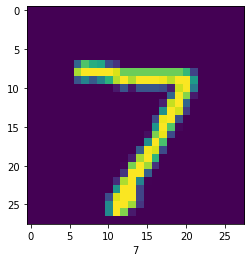

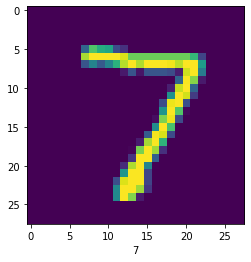

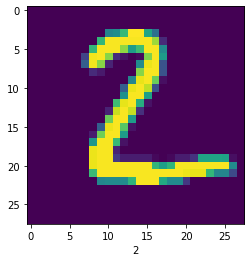

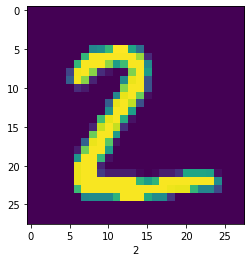

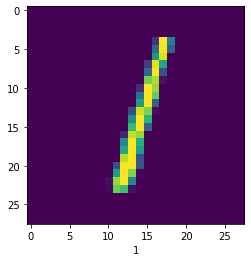

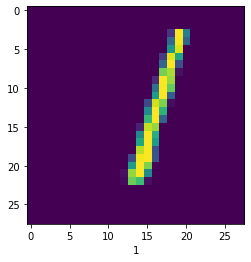

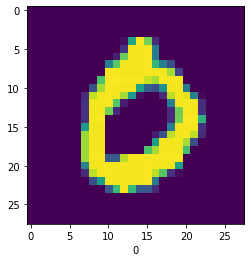

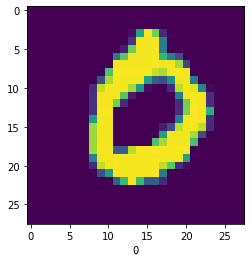

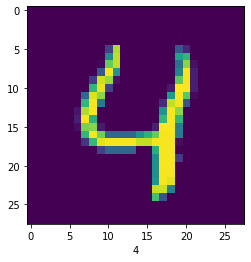

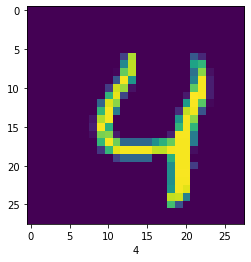

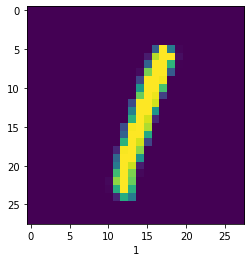

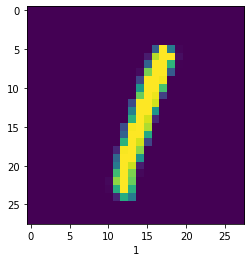

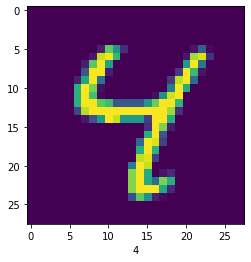

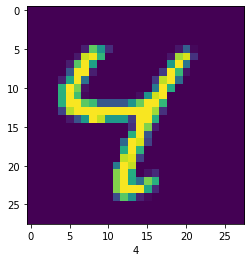

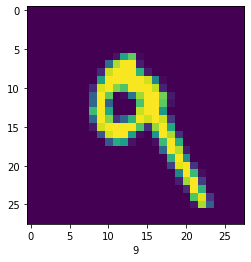

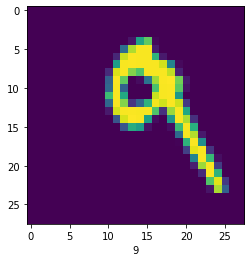

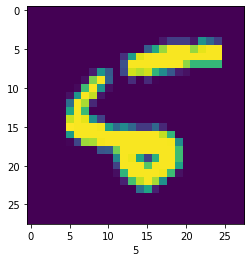

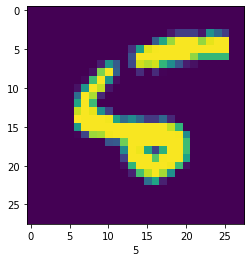

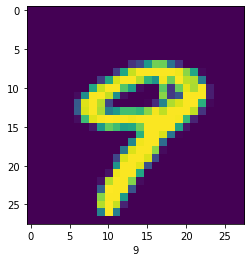

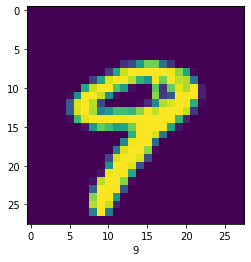

In [91]:
for id in range(0, 10):
    original_image = o_x[id]
    my_image = sm_x[id]

    printer.print_image(original_image, o_y[id], 28)
    printer.print_image(my_image, o_y[id], 28)

# Confusion Matrix

In [ ]:
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

def get_confusion_mat(model, batch, name):
    matrix = np.zeros((10,10))
    tot_imgs = 0
    
    with tqdm(total=len(batch)) as pbar:
        
        description = "Creating "+name+" confusion matrix"
        pbar.set_description_str(description)
        for X_batch, y_batch in batch:
            
            tot_imgs = tot_imgs + len(X_batch)
            
            res = model.predict(X_batch)
            for i in range(0, y_batch.shape[0]):
                
                matrix[y_batch[i], res[i]] += 1 # row, col
        
            pbar.update(1)

    return matrix, tot_imgs

def print_matrix(matrix, matrix_type, model_type, data_type, no_images, col_labels=0, row_labels=0, size_x=10, size_y=10, color="Blues"):
        headers = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
        
        title = model_type+" confusion matrix "+matrix_type+",\n on "+str(no_images/1000)+"K "+data_type+" images"
        x_label = "Actual Digit"
        y_label = "Predicted Digit"
        
        if row_labels != 0:
            fig, ax = plt.subplots(figsize=(size_x,size_y))
            mat = matrix.copy()
            mat = mat.transpose()
            
            ax = sns.heatmap(mat, annot=True, fmt='g', cmap=color, ax=ax)

            ax.set_title(title+'\n\n', size=size_x*1.9)
            ax.set_xlabel('\n'+y_label, size=size_x*1.5)
            ax.set_ylabel(x_label+' \n', size=size_x*1.5)
            
            ax3 = ax.twiny()
            # ax3.set_aspect("equal")
            ax3.set_xlabel("No. of occurencies\n", size=size_x*1.5)
            ax3.set_xlim([0,ax.get_xlim()[1]])
            ax3.set_xticks(ax.get_xticks())
            ax3.set_xticklabels(row_labels, fontsize=size_x*1)
            ax3.tick_params(top=False)
            ax3.spines['top'].set_visible(False)
            ax3.spines['right'].set_visible(False)
            ax3.spines['bottom'].set_visible(False)
            ax3.spines['left'].set_visible(False)
        else:
            fig, ax = plt.subplots(figsize=(size_x,size_y))
            ax = sns.heatmap(matrix, annot=True, fmt='g', cmap=color, ax=ax)

            ax.set_title(title+'\n\n', size=size_x*1.9)
            ax.set_xlabel('\n'+x_label, size=size_x*1.5)
            ax.set_ylabel(y_label+' \n', size=size_x*1.5)


        if col_labels != 0:            
            ax3 = ax.twiny()
            # ax3.set_aspect("equal")
            ax3.set_xlabel("No. of occurencies\n", size=size_x*1.5)
            ax3.set_xlim([0,ax.get_xlim()[1]])
            ax3.set_xticks(ax.get_xticks())
            ax3.set_xticklabels(col_labels, fontsize=size_x*1)
            ax3.tick_params(top=False)
            ax3.spines['top'].set_visible(False)
            ax3.spines['right'].set_visible(False)
            ax3.spines['bottom'].set_visible(False)
            ax3.spines['left'].set_visible(False)  

        ## Ticket labels - List must be in alphabetical order
        ax.xaxis.set_ticklabels(headers)
        ax.yaxis.set_ticklabels(headers)

        ## Display the visualization of the Confusion Matrix.
        plt.show()
        
def normalize_matrix(matrix, tot):
    mat = matrix.copy()
    for i in range(0, 10):
        for j in range(0, 10):
            mat[i, j] = (mat[i, j] / tot) * 100  
    return  np.around(mat, decimals=3)

def normalize_matrix_on_row(matrix):
    mat = matrix.copy()
    for c in range(0,10):
        
        mat[:,c] /= np.sum(mat[:,c])
        mat[:,c] *= 100 
                           
    return np.around(mat, decimals=3)

def normalize_matrix_on_columns(matrix):
    mat = matrix.copy()
    for r in range(0,10):
        
        mat[r,:] /= np.sum(mat[r,:])
        mat[r,:] *= 100
                           
    return np.around(mat, decimals=3)

def get_sum_row_matrix_label(matrix):
    res = []
    for c in range(0, 10):
        res.append( str( int( np.sum( matrix[:,c] ) ) ) )
    return res

def get_sum_colum_matrix_label(matrix):
    res = []
    for r in range(0, 10):
        res.append( str( int( np.sum( matrix[r,:] ) ) ) )
    return res

#matrix
#n = tot images : number
#v = model description : string
#dt = dataset type description : string
def print_all_matrix(mat, n, v, dt):
    print_matrix( normalize_matrix(mat, n),
                            'normalized on total images(%)', 
                            v, 
                            '{0} test'.format(dt),  
                             n)

    print_matrix( normalize_matrix_on_row(mat),
                            'normalized on on total images in row(%)', 
                            v, 
                            '{0} test'.format(dt),  
                             n,
                             row_labels=get_sum_row_matrix_label(mat))

    print_matrix( normalize_matrix_on_columns(mat),
                            'normalized on total images in column(%)', 
                            v, 
                            '{0} test'.format(dt),  
                             n,
                             col_labels=get_sum_colum_matrix_label(mat))

In [ ]:
#mnist matrix
#matrix, tot_images = get_confusion_mat(model, b_2, "MNIST/MNIST")

In [ ]:
model_version = "Model v2"
dataset_type = "MNIST"
print_all_matrix(matrix, tot_images, model_version, dataset_type)

# Confusion table

In [ ]:
from numpy import sqrt 
import pandas as pd

def _get_confusion_table_for(mat, digit, tot):
    
    dict_ = {}
    
    # condition positive (how many images were < digit >)
    p = 0
    for i in range(0, 10):
        p += mat[i, digit]
    dict_["Condition Positive"] = p
    
    #condition negative (how many images were not < digit > )
    n = tot - p
    dict_["Condition Negative"] = n 
    
    tp = mat[digit, digit]
    dict_["True Positive (TN)"] = tp
    
    fn = -tp
    for i in range(0, 10):
        fn += mat[i, digit]
    dict_["False Negative (FN)"] = fn
    
    fp = -tp
    for i in range(0, 10):
        fp += mat[digit, i]
    dict_["False Positive (FP)"] = fp 
    
    tn = tot + tp    
    for i in range(0, 10):
        tn -= mat[digit, i] + mat[i, digit]
    dict_["True Negative (TN)"] = tn 

    tpr = tp / p
    dict_["Sensitivity (TPR)"] = tpr 

    tnr = tn / n
    dict_["Specificity (TNR)"] = tnr 

    ppv = tp / (tp + fp)
    dict_["Positive Predictive Value (PPV)"] = ppv

    npv = tn / ( tn + fn )
    dict_["Negative Predictive Value (NPV)"] = npv 

    fnr = 1 - tpr
    dict_["False Negative Rate (FNR)"] = fnr 

    fpr = 1 - tnr
    dict_["False Positive Rate (FPR)"] = fpr 

    fdr = 1 - ppv
    dict_["False Discovery Rate (FDR)"] = fdr 

    for_ = 1 - npv
    dict_["False Omission Rate (FOR)"] = for_ 

    lr_p = tpr/fpr
    dict_["Positive Likelihood Ratio (LR+)"] = int(lr_p) 
    
    lr_n = fnr/tnr
    dict_["Negative Likelihood Ratio (LR-)"] = lr_n 

    pt = sqrt( fpr ) / ( sqrt(tpr) * sqrt(fpr) )
    dict_["Prevalence Threshold (PT)"] = pt 

    ts = tp / ( tp + fn + fp )
    dict_["Threat Score"] = ts 

    prevalence = p / tot
    dict_["Prevalence"] = prevalence 
    
    acc = ( tp + tn ) / tot
    dict_["Accuracy (ACC)"] = acc 

    ba = ( tpr * tnr ) / 2
    dict_["Balanced Accuracy"] = ba 

    f1 = ( 2*tp ) / ( 2*tp + fp + fn )
    dict_["F1 Score"] = f1 

    mcc = ( ( tp * tn ) - ( fp * fn ) ) / sqrt( ( tp+fp )*( tp*fn )*( tn+fp )*(tn+fn) )
    dict_["Matthews Correlation Coefficient (MCC)"] = mcc
    
    fm = sqrt( ppv * tpr )
    dict_["Fowlkes–Mallows Index (FM)"] = fm
    
    bm = tpr + tnr - 1
    dict_["Bookmaker Informedness (BM)"] = bm
    
    mk = ppv + npv - 1
    dict_["Markedness (MK)"] = mk
    
    #from 0 to inf
    dor = lr_p / lr_n
    dict_["Diagnostic odds ratio (DOR)"] = int(dor)
    
    header = np.array(list(dict_.keys()))
    values = np.array(list(dict_.values()))
    
    return values, header

def _trim(string):
    if string.endswith(".0"):
        return string[0:-2]
    return string

def _get_confusion_table(confusion_matrix, dataset_size):
    values = []
    index = []
    columns = []
    for i in range(0, 10):
        v, h = _get_confusion_table_for(confusion_matrix, i, dataset_size)
        values.append(v)
        index = h
        columns.append(i)
    
    values = np.around(np.array(values), decimals=3)
    index = np.array(index)
    columns = np.array(columns)

    return values, columns, index

def print_confusion_table(confusion_matrix, tot_images):
    values, columns, index = _get_confusion_table(confusion_matrix, tot_images)
    df = pd.DataFrame( values , index=columns, columns=index, dtype=str).T
    df.columns.name = "Digit"
    df = df.applymap(_trim)
    return df

In [ ]:
df = print_confusion_table(matrix, tot_images)
#print(df.to_latex())

### Error cases

In [ ]:
off = 44
n = 110
idx, pred = perfu.get_error_index(model, X_test[off:off+n], y_test[off:off+n], off)

print(idx)
print(pred)

In [ ]:
for i in range(len(idx)):
    img = idx[i]
    printer.print_image_and_prediction(X_test[img], y_test[img], pred[i], 40 )


### Network Conv1/PrimaryCapsule Output

In [ ]:
printer.print_network(model, X_test[45], y_test[45], 40)

### Network Kernels

In [ ]:
printer.print_fixed_network_params(model)